THis algorihtm combines quantum and classic approaches by splitting up the problem into smaller sections, that way you don't need to use as many qubits for a certain square (you actually only need shortest_side_lengt - 2) qubits but there is a constraint: you need to have every possible combo on the edge so the easiest is the cross, blank, horizontal, and vertical. You could also alterntaivly instead of the corss have the four L's but thats more qubits. This is a pretty heavy constraint but you need it because of how its partly classical.

A future way to ease this constriant slightly is to start at one corner to start generation. This has the benefit of that you only need to have all possible combos for two edges so you only have to have two sides constrained ex) instead of needing the four L's you only need 2. The main reason for this constriant is that because there is classic it doesn't have the quantum advantage of foresight that should be there on a large scale. Not really a way to completely remedy it that I can think of unless there's some gaurenteed patern but in most cases that specific to the tiles you have

How the algorithm works: you generate the middle tile a(4 tiles if even 1 if odd) then generate the sides and corners and go out from there. COuld be sped up with multiplexing/threading idk which one lol i always get thme mixed up.



In [10]:
!pip install qiskit
from qiskit import *
!pip install qiskit-aer
!pip install qiskit-optimization
!pip install qiskit_algorithms

In [11]:
import qiskit_algorithms
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import *
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np
import math

In [12]:
def get_filtered_samples(
    samples: List[SolutionSample],
    threshold: float = 0,
    allowed_status: Tuple[OptimizationResultStatus] = (OptimizationResultStatus.SUCCESS,),
):
    res = []
    for s in samples:
        if s.status in allowed_status and s.probability > threshold:
            res.append(s)

    return res

In [13]:
def generate_corners(combos, way1, way2, constrained1, constrained2):
  qubo = QuadraticProgram()
  #initializing variables
  for i in range(1):
      for k in combos:
        qubo.binary_var(f"{i}{k}")

  #number of options
  linear = [1] * (len(combos))
  qubo.minimize(linear=linear, quadratic={})
  constraints = {}
  constraintConstrained = {}
  total = 0
  curr = 1
  #only one in each box
  for k in range(1):
    total += curr
    for i in range(len(combos)):
      constraints[f"{k}{combos[i]}"] = curr
      constraintConstrained[f"{k}{combos[i]}"] = 0
    curr *= 10
  qubo.linear_constraint(linear=constraints, sense="==", rhs=total)

  curr = 1
  #Right and left
  for combo in combos: #for each combo
      constraintConstrained[f"{0}{combo}"] = (int(combo[way1]) + 1) * curr
      constraintConstrained[f"{0}{combo}"] += (int(combo[way2]) + 1) * curr * 10

  #constraintConstrained["block1"] = (int(constrained1) + 1) * -1
  #constraintConstrained["block2"] = (int(constrained2) + 1) * -10
  qubo.linear_constraint(linear=constraintConstrained, sense="==", rhs=((int(constrained1) + 1)  + (int(constrained2) + 1) * 10))

  #Quantum part
  converter = QuadraticProgramToQubo()
  qubo_with_penalty = converter.convert(qubo)
  op, offset = qubo_with_penalty.to_ising()
  qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())
  qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
  qaoa_result = qaoa.solve(qubo)

  filtered_samples = get_filtered_samples(
    qaoa_result.samples, threshold=0.00001, allowed_status=(OptimizationResultStatus.SUCCESS,)
  )

  samples_for_plot = {}
  for s in filtered_samples:
        x = 0
        sample_str = " ".join(f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x))

        samples_for_plot[sample_str] = s.probability
  length = len(samples_for_plot)
  samples_for_plot = {}
  w, h = 1, length #h is number probailitues
  arr = [[0 for x in range(w)] for y in range(h)]
  l = 0

  for s in filtered_samples:
      x = 0
      sample_str = " ".join(f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x))

      samples_for_plot[sample_str] = s.probability
      for i, v in enumerate(s.x):
          if int(v) == 1 and x < 2:
              arr[l][x] = qaoa_result.variables[i].name[1:]
              x+=1
      l += 1
  return arr[0]


In [14]:
def generate_base(combos, shortest_side):
  if shortest_side % 2 == 0:
    side_length = 2
  else:
    side_length = 1

  qubo = QuadraticProgram()
  #initializing variables
  for i in range(side_length):
      for k in combos:
        qubo.binary_var(f"{i}{k}")

  #number of options
  linear = [1] * (side_length * len(combos))
  qubo.minimize(linear=linear, quadratic={})

  constraints = {}
  total = 0
  constraintRand = {}
  curr = 1

  #only one in each box
  for k in range(side_length):
    total += curr
    for i in range(len(combos)):
      constraintRand[f"{k}{combos[i]}"] = 0
      constraints[f"{k}{combos[i]}"] = curr
    curr *= 10
  qubo.linear_constraint(linear=constraints, sense="==", rhs=total)

  if (side_length > 1):
    #Right and left must be aligned
  #Way your not looking at
    curr = 1
    for i in range(side_length):
      if i == 0: #if we're on one side of the end we only looks at the right value
        curr *= 10
        for combo in combos: #for each combo
          constraintRand[f"{i}{combo}"] = constraintRand[f"{i}{combo}"] + ((int(combo[1]) + 1) * curr)
      elif i  == (side_length - 1): #if we're on other side of end
          for combo in combos:
            constraintRand[f"{i}{combo}"] = constraintRand[f"{i}{combo}"] + ((int(combo[3]) + 1) * curr) * -1 #only looks at the left value
      else: #if we're in middle
          for combo in combos:
            constraintRand[f"{i}{combo}"] = constraintRand[f"{i}{combo}"] + ((int(combo[3]) + 1) * curr) * -1
          curr *= 10 #we multiply in the middle since we want the left to be same as previous right
          for combo in combos:
            constraintRand[f"{i}{combo}"] = constraintRand[f"{i}{combo}"] + ((int(combo[1]) + 1) * curr)
    qubo.linear_constraint(linear=constraintRand, sense="==", rhs=0)

  #quanutm stuff
  converter = QuadraticProgramToQubo()
  qubo_with_penalty = converter.convert(qubo)
  op, offset = qubo_with_penalty.to_ising()
  qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())
  qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
  qaoa_result = qaoa.solve(qubo)

  filtered_samples = get_filtered_samples(
    qaoa_result.samples, threshold=0.00001, allowed_status=(OptimizationResultStatus.SUCCESS,)
  )

  samples_for_plot = {}
  for s in filtered_samples:
        x = 0
        sample_str = " ".join(f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x))

        samples_for_plot[sample_str] = s.probability
  length = len(samples_for_plot)
  samples_for_plot = {}
  w, h = side_length, length #h is number probailitues
  arr = [[0 for x in range(w)] for y in range(h)]
  l = 0

  for s in filtered_samples:
      x = 0
      sample_str = " ".join(f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x))

      samples_for_plot[sample_str] = s.probability
      for i, v in enumerate(s.x):
          if int(v) == 1 and x < 2:
              arr[l][x] = qaoa_result.variables[i].name[1:]
              x+=1
      l += 1
  return arr[len(arr) - 1]


In [15]:
def generate_side(side_length, way, desired, combos):
  qubo = QuadraticProgram()
  #initializing variables
  for i in range(side_length):
      for k in combos:
        qubo.binary_var(f"{i}{k}")
  for i in range(side_length):
    qubo.binary_var(f"block{i}")

  #number of options
  linear = [1] * (side_length * len(combos) + side_length)
  qubo.minimize(linear=linear, quadratic={})

  constraints = {}
  constraintRand = {}
  constraintConstrained = {}
  total = 0
  curr = 1

  #only one in each box
  for k in range(side_length):
    total += curr
    for i in range(len(combos)):
      constraints[f"{k}{combos[i]}"] = curr
      constraintRand[f"{k}{combos[i]}"] = 0
      constraintConstrained[f"{k}{combos[i]}"] = 0
    curr *= 10
  qubo.linear_constraint(linear=constraints, sense="==", rhs=total)
  #Way your not looking at
  if (way % 2 == 0):
    ####### TOP-DOWN GEN STARTS ##########################################################################
    curr = 1
    if (side_length > 1):
      for i in range(side_length):
        if i == 0: #if we're on one side of the end we only looks at the right value
          curr *= 10
          for combo in combos: #for each combo
            constraintRand[f"{i}{combo}"] = constraintRand[f"{i}{combo}"] + ((int(combo[1]) + 1) * curr)
        elif i  == (side_length - 1): #if we're on other side of end
            for combo in combos:
              constraintRand[f"{i}{combo}"] = constraintRand[f"{i}{combo}"] + ((int(combo[3]) + 1) * curr) * -1 #only looks at the left value
        else: #if we're in middle
            for combo in combos:
              constraintRand[f"{i}{combo}"] = constraintRand[f"{i}{combo}"] + ((int(combo[3]) + 1) * curr) * -1
            curr *= 10 #we multiply in the middle since we want the left to be same as previous right
            for combo in combos:
              constraintRand[f"{i}{combo}"] = constraintRand[f"{i}{combo}"] + ((int(combo[1]) + 1) * curr)
      qubo.linear_constraint(linear=constraintRand, sense="==", rhs=0)

    curr = 1
    #top and bottom must be aligned correctly
    for i in range(side_length):
          for combo in combos: #for each combo
            constraintConstrained[f"{i}{combo}"] = (int(combo[(way+2)%4]) + 1) * curr
          constraintConstrained[f"block{i}"] = (int(desired[i][way]) + 1) * -1 * curr
          curr *= 10
    qubo.linear_constraint(linear=constraintConstrained, sense="==", rhs=0)
  else:
    ####### RIGHT_LEFT STARTS ##########################################################################
      for i in range(side_length):
        for combo in combos: #for each combo
          constraintConstrained[f"{i}{combo}"] = (int(combo[(way+2)%4]) + 1) * curr
        constraintConstrained[f"block{i}"] = (int(desired[i][way]) + 1) * -1 * curr
        curr *= 10
      qubo.linear_constraint(linear=constraintConstrained, sense="==", rhs=0)

      #Right and left must be aligned
      #Way your not looking at

      curr = 1
      if (side_length > 1):
        for i in range(side_length):
          if i == 0: #if we're on one side of the end we only looks at the right value
            curr *= 10
            for combo in combos: #for each combo
              constraintRand[f"{i}{combo}"] = constraintRand[f"{i}{combo}"] + ((int(combo[2]) + 1) * curr)
          elif i  == (side_length - 1): #if we're on other side of end
              for combo in combos:
                constraintRand[f"{i}{combo}"] = constraintRand[f"{i}{combo}"] + ((int(combo[0]) + 1) * curr) * -1 #only looks at the left value
          else: #if we're in middle
              for combo in combos:
                constraintRand[f"{i}{combo}"] = constraintRand[f"{i}{combo}"] + ((int(combo[0]) + 1) * curr) * -1
              curr *= 10 #we multiply in the middle since we want the left to be same as previous right
              for combo in combos:
                constraintRand[f"{i}{combo}"] = constraintRand[f"{i}{combo}"] + ((int(combo[2]) + 1) * curr)
      qubo.linear_constraint(linear=constraintRand, sense="==", rhs=0)
  ####### RIGHT-LEFT ENDS ##########################################################################
    #quanutm stuff
  converter = QuadraticProgramToQubo()
  qubo_with_penalty = converter.convert(qubo)
  op, offset = qubo_with_penalty.to_ising()
  qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA())
  qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
  qaoa_result = qaoa.solve(qubo)

  filtered_samples = get_filtered_samples(
    qaoa_result.samples, threshold=0.00001, allowed_status=(OptimizationResultStatus.SUCCESS,)
  )
  samples_for_plot = {}
  for s in filtered_samples:
        x = 0
        sample_str = " ".join(f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x))

        samples_for_plot[sample_str] = s.probability

  length = len(samples_for_plot)
  samples_for_plot = {}
  w, h = side_length, length #h is number probailitues
  arr = [[0 for x in range(w)] for y in range(h)]

  l = 0

  for s in filtered_samples:
      x = 0
      sample_str = " ".join(f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x))
      samples_for_plot[sample_str] = s.probability
      for i, v in enumerate(s.x[:-1*side_length]):
          if int(v) == 1 and x < 2:
              arr[l][x] = qaoa_result.variables[i].name[1:]
              x+=1
      l += 1
  return arr[0]

In [16]:
def set_elements_rows(array, x, y, values):
    # Set elements in row x from column y to y+len(values)-1
    array[x][y:y+len(values)] = values

In [17]:
def set_elements_cols(array, x, y, values):
    num_rows = len(values)
    # Set elements in rows x to x + num_rows - 1
    for i in range(num_rows):
        array[x + i][y] = values[i]

In [82]:
def generate_map(width, height, combos):
  smallest_dimension = int(min(width,height))
  half_smallest_dimension= int(smallest_dimension/2)

  ########### GENERATING BASE ##########################################
  base = generate_base(combos, smallest_dimension )
  arr = [[-1 for _ in range(width)] for _ in range(height)]
  top,right,left,bottom = half_smallest_dimension, half_smallest_dimension, half_smallest_dimension, half_smallest_dimension
  curr_side_len = 2

  if ( smallest_dimension % 2 == 0):
    top = half_smallest_dimension - 1
    left = half_smallest_dimension - 1
    base_top_half = generate_side(2,0,base,combos)
    arr[(half_smallest_dimension)-1][(half_smallest_dimension)-1] = base_top_half[0]
    arr[(half_smallest_dimension)-1][(half_smallest_dimension)] = base_top_half[1]
    arr[(half_smallest_dimension)][(half_smallest_dimension)-1] = base[0]
    arr[(half_smallest_dimension)][(half_smallest_dimension)] = base[1]

  else:
    curr_side_len = 1
    arr[half_smallest_dimension][half_smallest_dimension] = base[0]

  ########### GENERATING SQUARE ##########################################
  while curr_side_len <= ((smallest_dimension)-2):
    top_side = generate_side(curr_side_len,0,arr[top][left:right+1],combos)
    bottom_side = generate_side(curr_side_len,2,arr[bottom][left:right+1],combos)
    right_side = generate_side(curr_side_len,1,[row[right] for row in arr[top:bottom + 1]],combos)
    left_side = generate_side(curr_side_len,3,[row[left] for row in arr[top:bottom + 1]],combos)
    set_elements_rows(arr, top-1, left, top_side)
    set_elements_rows(arr, bottom+1, left, bottom_side)
    set_elements_cols(arr,  top, left-1, left_side)
    set_elements_cols(arr,  top, right+1, right_side)
    top -= 1
    bottom +=1
    right += 1
    left -=1
    curr_side_len+=2


    ##now generating corners ugh
    arr[top][left] = generate_corners(combos, 1, 2, arr[top][left+1][3], arr[top+1][left][0])[0]
    arr[top][right]  = generate_corners(combos, 2, 3, arr[top+1][right][0], arr[top][right-1][1])[0]
    arr[bottom][left] = generate_corners(combos, 0, 1, arr[bottom-1][left][2], arr[bottom][left+1][3])[0]
    arr[bottom][right]  = generate_corners(combos, 0, 3, arr[bottom-1][right][2], arr[bottom][right-1][1])[0]


  while (right-left+1) < width: #its lacking in width, generate to the right
    right_side = generate_side(curr_side_len,1,[row[right] for row in arr[top:bottom + 1]],combos)
    right += 1
    set_elements_cols(arr,  top, right, right_side)


  while(bottom-top+1) < height: #its lacking in hegith, generate to the bottom
    bottom_side = generate_side(curr_side_len,2,[col[bottom]for col in arr[left:right+1]],combos)
    bottom +=1
    set_elements_rows(arr, bottom, left, bottom_side)
  return arr

In [42]:
# TODO: generate picture
import matplotlib.pyplot as plt
import numpy as np

def drawCorner(grid, ind, row, col, box):
    if box[ind] == '1':
        grid[row, col] = [0, 0, 0]

def drawBox(box):
    grid = np.ones((3, 3, 3))
    if box != "0000":
        grid[1, 1] = [0, 0, 0]

    drawCorner(grid, 0, 0, 1, box)
    drawCorner(grid, 1, 1, 2, box)
    drawCorner(grid, 2, 2, 1, box)
    drawCorner(grid, 3, 1, 0, box)
    return grid

def drawMap(map_arr, col, row):
    h_arr = []
    for i in range(row):
        row_arr = []
        for j in range(col):
            row_arr.append(drawBox(map_arr[i][j]))  # Note: map_arr[j][i] should be map_arr[i][j]
        h_arr.append(np.hstack(row_arr))
    graph = np.vstack(h_arr)
    plt.imshow(graph)
    plt.axis('off')
    plt.show()
    print("")


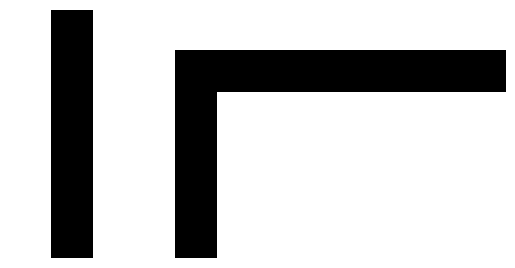

In [43]:
combos = ['0000','0110','1111', '0101', '1010']
graph_arr_rep = generate_map(4,2,combos)
drawMap(graph_arr_rep, 4, 2)

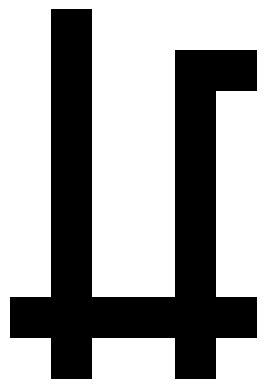

In [84]:
graph_arr_rep = generate_map(2,3,combos)
drawMap(graph_arr_rep, 2, 3)

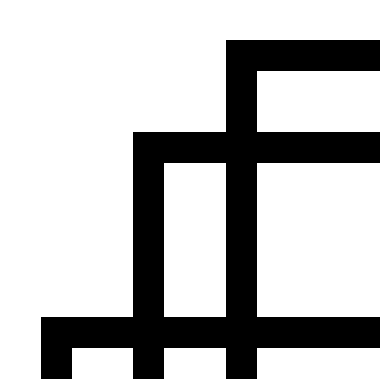

In [83]:
graph_arr_rep = generate_map(4,4,combos)
drawMap(graph_arr_rep, 4, 4)